In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [21]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [22]:
df.isnull().sum()

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


In [23]:
df = df.dropna()

In [24]:
cat_cols = df.select_dtypes(include=["object"]).columns
cat_cols

Index(['Gender', 'Occupation', 'BMI Category', 'Blood Pressure',
       'Sleep Disorder'],
      dtype='object')

In [25]:
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

In [26]:
X = df.drop("Sleep Disorder", axis=1)
y = df["Sleep Disorder"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:
model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [28]:
y_pred = model.predict(X_test)

In [29]:
import numpy as np
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities))
def information_gain(X_column, y, split_value):
    left_idx = X_column <= split_value
    right_idx = X_column > split_value

    if sum(left_idx) == 0 or sum(right_idx) == 0:
        return 0

    left_entropy = entropy(y[left_idx])
    right_entropy = entropy(y[right_idx])

    p_left = len(y[left_idx]) / len(y)
    p_right = 1 - p_left

    parent_entropy = entropy(y)

    gain = parent_entropy - (p_left * left_entropy + p_right * right_entropy)
    return gain

def best_split(X, y):
    best_feature = None
    best_value = None
    best_gain = -1

    for feature in X.columns:
        values = X[feature].unique()
        for v in values:
            gain = information_gain(X[feature].values, y.values, v)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_value = v
    return best_feature, best_value, best_gain

class Node:
    def __init__(self, feature=None, value=None, left=None, right=None, label=None):
        self.feature = feature
        self.value = value
        self.left = left
        self.right = right
        self.label = label


def build_tree(X, y, depth=0, max_depth=5):

    if len(np.unique(y)) == 1:
        return Node(label=y.iloc[0])

    if depth >= max_depth:
        most_common = y.value_counts().idxmax()
        return Node(label=most_common)

    feature, value, gain = best_split(X, y)

    if gain == 0:
        most_common = y.value_counts().idxmax()
        return Node(label=most_common)

    left_mask = X[feature] <= value
    right_mask = X[feature] > value

    left_node = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_node = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)

    return Node(feature, value, left_node, right_node)

def predict_one(x, tree):
    while tree.label is None:
        if x[tree.feature] <= tree.value:
            tree = tree.left
        else:
            tree = tree.right
    return tree.label


def predict(X, tree):
    return np.array([predict_one(x, tree) for _, x in X.iterrows()])


In [30]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8064516129032258


In [31]:
print("Precision:", precision_score(y_test, y_pred, average="weighted"))

Precision: 0.8064516129032258


In [32]:
print("Recall:", recall_score(y_test, y_pred, average="weighted"))

Recall: 0.8064516129032258


In [33]:
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))

F1 Score: 0.8064516129032258


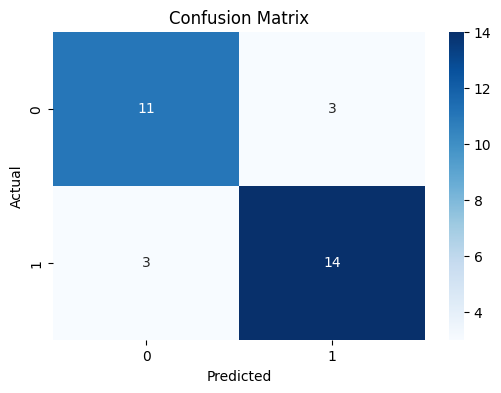

In [34]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

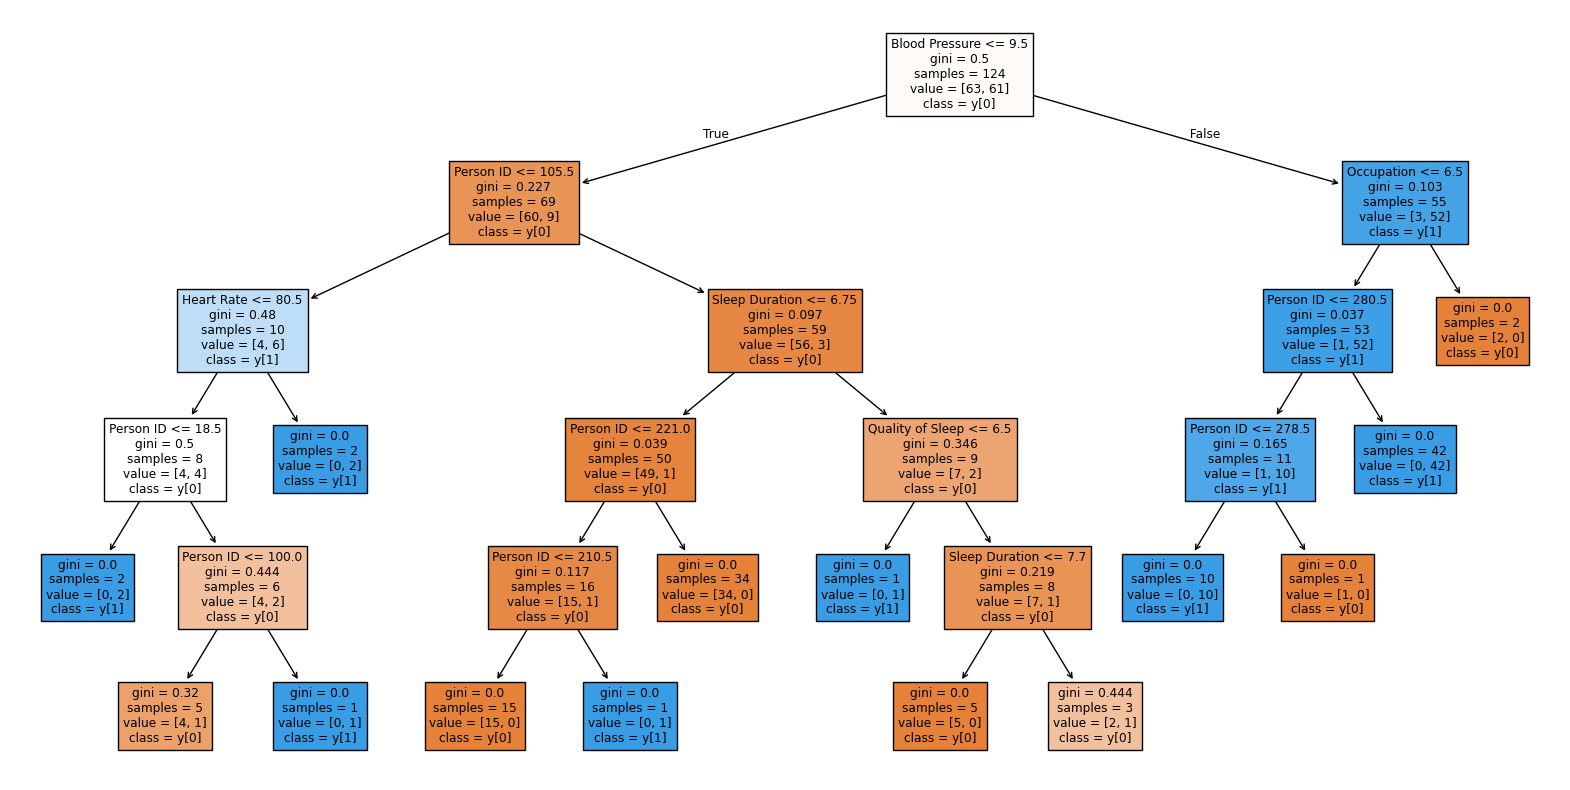

In [35]:
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, class_names=True, filled=True)
plt.show()

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop("Sleep Duration", axis=1)
y = df["Sleep Duration"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

reg = DecisionTreeRegressor(max_depth=5, random_state=42)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MSE: 0.006219390905746489
R² Score: 0.9905835097989312
